# Simulation of likelhood fitting

In this notebook, I simulate spike counts data from a known distribution, and fit a DNN to recover the likelihood function. I then compare the recovered likelihood functions to the "ground-truth" likelhood functions computed from the known distribution.

In [292]:
import datajoint as dj
import numpy as np
import torch
from torch.autograd import Variable
from torch.nn.init import normal, constant
from torch import nn
from matplotlib import pyplot as plt
from attorch.train import early_stopping
from torch.utils.data import TensorDataset, DataLoader
import seaborn as sns
sns.set_context('notebook', font_scale=1.3)

%matplotlib inline

from numpy.linalg import inv, svd

from v1_likelihood import train
from v1_likelihood.train import CVTrainedModel, ModelDesign, BinConfig, CVSet, CVTrainedModel

dj.config['display.limit'] = 40

In [293]:
def stat_logp(lp):
    nbins = lp.size(1)
    v = lp - lp.max(dim=1, keepdim=True)[0]
    post = torch.exp(v)
    ro_pos = Variable(torch.arange(nbins).type(post.data.type()))
    mu = (ro_pos*post).sum(dim=1, keepdim=True) / post.sum(dim=1, keepdim=True)
    sigma = torch.sqrt(((ro_pos - mu).pow(2)*post).sum(dim=1) / post.sum(dim=1))
    mu = mu.view(mu.numel())
    return mu, sigma

## Simulate data

First, I simulate stimulus orientation drawn from the mixture of two Gaussian distributions. Both have $\mu=270^\circ$ but standard deviations differ $\sigma_A = 3^\circ$ and $\sigma_B = 15^\circ$.

In [294]:
sigmaA = 3
sigmaB = 15
stim_center = 270

In [295]:
n_trials = 1000
sv = np.random.choice([sigmaA, sigmaB], size=n_trials)
ori = np.random.randn(n_trials) * sv + stim_center

Now I simulate spike counts over an array consisting of 96 "multi-units". I assign a preferred orientation $\theta$ to each multi-unit. Each multi-unit has a Gaussian orietation tuning curve centered at it's preferred orientation. The standard deviation and the amplitude of the Gaussian tuning curves are identical for all multi-units in this simple simulation.

### Prepare, a random fixed correlation

In [544]:
from numpy.linalg import matrix_rank

from numpy.linalg import inv

a = np.random.rand(96, 10) - 0.5
s = a @ a.T + np.eye(96)*0.1

f = np.diag(1/np.sqrt(np.diag(s)))

ss = f @ s @ f   # normalize the marginals

assert matrix_rank(ss)==96

np.abs(ss - np.eye(96)).mean()

In [545]:
def sample_normal(N, sigma):
    u, sv, ht = svd(sigma)
    x = np.random.randn(96, N)
    return u @ np.diag(np.sqrt(sv)) @ x

In [546]:
noise = sample_normal(n_trials, ss).T

In [696]:
noise.shape

(1000, 96)

In [700]:
n_ch = 96
centers = np.linspace(-40, 40, n_ch)[:, None] + 270
sigmas = 30
#amplitude = 10 
#amplitude = np.random.rand(n_trials)*0 + 1.5
#amplitude = 3 * np.ones(n_trials)#np.random.rand(n_trials)*3 + 1.5
amplitude = np.random.choice([1], size=n_trials)

# this is the expected value of the spike counts for each stimulus
mus = (amplitude * np.exp(-(ori - centers)**2/2/sigmas**2)).T

# we then draw spike count samples from the independent Poisson distribution
counts = mus + noise * np.sqrt(mus)

prior_raw = np.log(np.exp(- pv**2 / 2 / sigmaA**2) / sigmaA + np.exp(- pv**2 / 2 / sigmaB**2) / sigmaB)

Specify orientation binning parameters and center of bins

In [701]:
nbins = 91
delta = 1
pv = (np.arange(nbins) - nbins//2) * delta

Here I go ahead and compute the log-likelihood $\log p(\mathbf{r}|s)$ already. The prior is computed here as well.

In [729]:
f = amplitude[:, None, None] * np.exp(-(centers-pv-270)**2 /2/sigmas**2)
logl = (counts[..., None] * np.log(f)).sum(axis=1) - f.sum(axis=1)
#f = amplitude * np.exp(-(centers-pv-270)**2 / sigmas**2)
#logl = counts @ np.log(f) - f.sum(axis=0)

Correct way to compute logl

In [703]:
f = amplitude[:, None, None] * np.exp(-(centers-pv-270)**2 /2/sigmas**2)
v = (counts[..., None] - f) / np.sqrt(f)

ss_inv = inv(ss)

vv = np.transpose(v, [1, 2, 0])
shape = vv.shape
vv = vv.reshape(shape[0], -1)

logl = (-(vv * (ss_inv @ vv)).sum(axis=0)/2).reshape(*shape[1:]).T

In [704]:
ct = counts.T

mu_counts = (ct * ori).sum(axis=1, keepdims=True) / ct.sum(axis=1, keepdims=True)
sigma_counts = np.sqrt((ct * ori**2).sum(axis=1, keepdims=True) / ct.sum(axis=1, keepdims=True) - mu_counts**2)
max_counts = counts.max(axis=0)

from scipy.optimize import curve_fit


def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/2/(sigma**2))

curve_fit(gaus, ori, counts[:, 0], p0=[max_counts[0], mu_counts[0], sigma_counts[0]])

(array([  0.79310536, 239.83889529,  27.17364465]),
 array([[ 9.71665458e-03, -6.05624984e-01,  2.60220181e-01],
        [-6.05624984e-01,  6.77653225e+01, -4.23469756e+01],
        [ 2.60220181e-01, -4.23469756e+01,  3.10324549e+01]]))

In [732]:
p = np.round((ori - stim_center)/ delta) + (nbins//2)
pos = (p >= 0) & (p < nbins)

# remove trials with orientation falling out of the binned orientation domain
p_p = p[pos]
counts_p = counts[pos]
logl_p = logl[pos]
amplitude_p = amplitude[pos]

# split into train, validation, and test set
fraction = 0.8
N = len(counts_p)
np.random.seed(123)
split = round(N * fraction)
pos = np.random.permutation(N)
train_pos = pos[:split]
valid_pos = pos[split:]

train_counts = counts_p[train_pos]
train_ori = p_p[train_pos]
train_logl = logl_p[train_pos]
train_logl = train_logl - train_logl.max(axis=1, keepdims=True)
train_amp = amplitude_p[train_pos]

valid_counts = counts_p[valid_pos]
valid_ori = p_p[valid_pos]

valid_logl = logl_p[valid_pos]
valid_logl = valid_logl - valid_logl.max(axis=1, keepdims=True)
valid_amp = amplitude_p[valid_pos]

Turn datasets into tensors and place them on GPU as needed.

In [733]:
train_x = torch.Tensor(train_counts)
train_t = torch.Tensor(train_ori).type(torch.LongTensor)

valid_x = Variable(torch.Tensor(valid_counts)).cuda()
valid_t = Variable(torch.Tensor(valid_ori).type(torch.LongTensor)).cuda()

prior = Variable(torch.Tensor(prior_raw)).cuda()

train_dataset = TensorDataset(train_x, train_t)
valid_dataset = TensorDataset(valid_x, valid_t)

## Network definition and training

Define the simple multi-layer fully-connected neural network.

In [708]:
class Net(nn.Module):
    def __init__(self, n_channel=96, n_hidden=100, n_output=nbins, dropout=0.1, std=0.01):
        super().__init__()
        self.n_channel = n_channel
        self.std = std
        self.n_output = n_output
        self.dropout = dropout
        
        if not isinstance(n_hidden, (list, tuple)):
            n_hidden = (n_hidden,)
        
        self.n_hidden = n_hidden
        
        n_prev = n_channel
        
        hiddens = []
        
        for n in n_hidden:
            hiddens.append(nn.Linear(n_prev, n))
            hiddens.append(nn.ReLU())
            if dropout > 0.0:
                hiddens.append(nn.Dropout(p=dropout, inplace=True))
            n_prev = n
        if len(hiddens) > 0:
            self.hiddens = nn.Sequential(*hiddens)
        else:
            self.hiddens = None
        self.ro_layer = nn.Linear(n_prev, n_output)
        
        self.initialize()
        
        
    def forward(self, x):
        if self.hiddens is not None:
            x = self.hiddens(x)
        x = self.ro_layer(x)
        return x
    
    def initialize(self):
        def fn(mod):
            if isinstance(mod, nn.Linear):
                normal(mod.weight, std=self.std)
                constant(mod.bias, 0)
        self.apply(fn)

Also define the objective function used during early-stopping

In [709]:
def stat_logp(lp):
    nbins = lp.size(1)
    v = lp - lp.max(dim=1, keepdim=True)[0]
    post = torch.exp(v)
    ro_pos = Variable(torch.arange(nbins).type(post.data.type()))
    mu = (ro_pos*post).sum(dim=1, keepdim=True) / post.sum(dim=1, keepdim=True)
    sigma = torch.sqrt(((ro_pos - mu).pow(2)*post).sum(dim=1) / post.sum(dim=1))
    mu = mu.view(mu.numel())
    return mu, sigma

In [710]:
def objective(net, x=None, t=None):
    if x is None and t is None:
        x = valid_x
        t = valid_t
    net.eval()
    y = net(x)
    posterior = y + prior
    #_, loc = torch.max(posterior, dim=1)
    loc, _ = stat_logp(posterior)
    diff = t.double() - loc.double()
    v =diff.pow(2).mean().sqrt() * delta
    return v.data.cpu().numpy()[0]
    #return loss(valid_y, valid_t).data.cpu().numpy()[0]

## Try linear regression

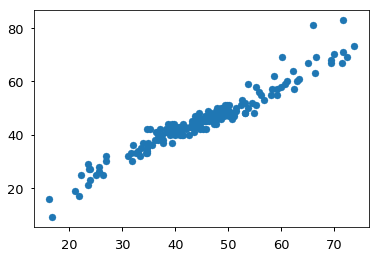

In [711]:
def extend_ones(x):
    return np.concatenate([x, np.ones([x.shape[0], 1])], axis=1)

tc = extend_ones(train_counts)

w = inv(tc.T @ tc + np.diag(np.ones(tc.shape[1]) * 0.0001)) @ tc.T @ train_ori

t_hat = extend_ones(valid_counts) @ w

plt.scatter(t_hat, valid_ori)

In [712]:
np.sqrt(np.mean((t_hat - valid_ori)**2)) * delta

2.866085783337903

## Fit NN

In [713]:
net = Net(n_channel=n_ch, n_output=nbins, n_hidden=[400, 400], std=0.0001, dropout=0.4)
net.cuda()
loss = nn.CrossEntropyLoss().cuda()

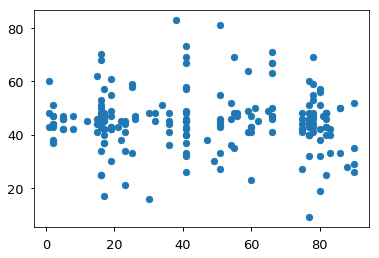

In [714]:
yv = net(valid_x).data.cpu().numpy()
loc = np.argmax(yv, axis=1)
plt.scatter(loc, valid_ori)

## Ground truth

On training set

4.354285 5.05843051728949


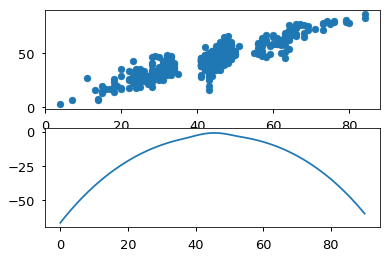

In [734]:
y = Variable(torch.Tensor(train_logl).cuda())
y = y + prior
gt_sigma =  (stat_logp(y)[1] * delta).data.cpu().numpy().mean()
#idx, _ = stat_logp(y)
val, idx = torch.max(y, 1)
yd = y.data.cpu().numpy()


plt.subplot(211)
t_hat = idx.data.cpu().numpy()
plt.scatter(t_hat, train_ori)


print(gt_sigma, np.sqrt(np.mean((t_hat.ravel() - train_ori)**2)) * delta)

plt.subplot(212)

plt.plot(yd[47])

On validation set

4.2555428 5.246903848937962


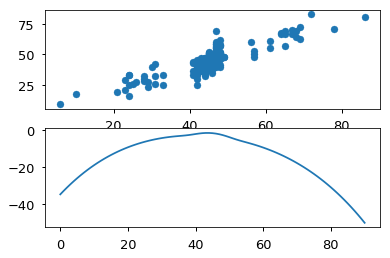

In [735]:
y = Variable(torch.Tensor(valid_logl).cuda())
y = y + prior
gt_sigma =  (stat_logp(y)[1] * delta).data.cpu().numpy().mean()
#idx, _ = stat_logp(y)
val, idx = torch.max(y, 1)
yd = y.data.cpu().numpy()


plt.subplot(211)
t_hat = idx.data.cpu().numpy()
plt.scatter(t_hat, valid_ori)


print(gt_sigma, np.sqrt(np.mean((t_hat.ravel() - valid_ori)**2)) * delta)

plt.subplot(212)

plt.plot(yd[47])

10.68335 10.868532559642079


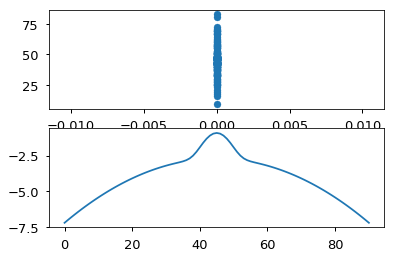

In [717]:
net.eval()
y = net(valid_x)
y = y + prior

gt_sigma =  (stat_logp(y)[1] * delta).data.cpu().numpy().mean()


idx, _ = stat_logp(y)
#val, idx = torch.max(y, 1)
yd = y.data.cpu().numpy()


plt.subplot(211)
t_hat = idx.data.cpu().numpy()
plt.scatter(t_hat, valid_ori)


print(gt_sigma, np.sqrt(np.mean((t_hat - valid_ori)**2)) * delta)

plt.subplot(212)

plt.plot(yd[64])

In [718]:
net.std = 1e-2
net.initialize()

alpha = 300 #3e-2 #7e-3 #1e-3


#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3000, gamma=0.3)
learning_rates = 0.03 * 3.0**(-np.arange(3))

for lr in learning_rates:
    print('\n\n\n\n LEARNING RATE: {}'.format(lr))
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    for epoch, valid_score in early_stopping(net, objective, interval=20, start=100, patience=20, max_iter=300000, maximize=False):
        data_loader = DataLoader(train_dataset, shuffle=True, batch_size=128)
        for x_, t_ in data_loader:
            x, t = Variable(x_).cuda(), Variable(t_).cuda()
            net.train()
            optimizer.zero_grad()
            y = net(x)
            post = y + prior
            val, _ = post.max(1, keepdim=True)
            post = post - val
            #sparcity = y.abs().sum(1).mean()
            conv_filter = Variable(torch.from_numpy(np.array([-0.25, 0.5, -0.25])[None, None, :]).type(y.data.type()))
            smoothness = nn.functional.conv1d(y.unsqueeze(1), conv_filter).pow(2).mean()
            score = loss(post, t)
            score = score + alpha * smoothness
            score.backward()
            optimizer.step()
        if epoch % 10 == 0:
            print('Score: {}'.format(score.data.cpu().numpy()[0]))
        #scheduler.step()





 LEARNING RATE: 0.03
Score: 3.8946080207824707
Score: 3.6383473873138428
[120|00/20] ---> 10.868296673913504
Score: 3.680233955383301
Score: 3.468032121658325
[140|00/20] ---> 10.868064473641773
Score: 3.620710849761963
Score: 3.605020046234131
[160|00/20] ---> 10.867908038007085
Score: 3.5508880615234375
Score: 3.5791609287261963
[180|00/20] ---> 10.867755641753629
Score: 3.6914782524108887
Score: 3.4007387161254883
[200|00/20] ---> 10.867537881496963
Score: 3.8411669731140137
Score: 3.6348280906677246
[220|00/20] ---> 10.867288202781651
Score: 3.141352891921997
Score: 3.4688069820404053
[240|00/20] ---> 10.866870082509076
Score: 3.490068197250366
Score: 3.5452919006347656
[260|00/20] ---> 10.866374519775668
Score: 3.683680534362793
Score: 3.525083541870117
[280|00/20] ---> 10.86567169231398
Score: 3.86249041557312
Score: 3.320330858230591
[300|00/20] ---> 10.864732130957155
Score: 3.9535090923309326
Score: 3.473276138305664
[320|00/20] ---> 10.86345957903812
Score: 3.381111383438

In [719]:
objective(net, Variable(train_x).cuda(), Variable(train_t).cuda())

1.5047558622334491

In [720]:
objective(net, valid_x, valid_t)

2.592216102145169

In [721]:
y = net(valid_x)
yd = y.data.cpu().numpy()
yd = np.exp(yd)
yd = yd / yd.sum(axis=1, keepdims=True)

loc = stat_logp(y)[0].data.cpu().numpy()
ds = (np.arange(nbins) - loc[:, None]) ** 2
avg_sigma = np.mean(np.sqrt(np.sum(yd * ds, axis=1))) * delta

In [722]:
avg_sigma

7.045384284127165

In [723]:
mu, s = stat_logp(y)

In [724]:
s.data.cpu().numpy().mean()

7.0453844

BlendedAffine2D(
    IdentityTransform(),
    BboxTransformTo(
        TransformedBbox(
            Bbox(x0=0.125, y0=0.125, x1=0.35294117647058826, y1=0.34705882352941175),
            BboxTransformTo(
                TransformedBbox(
                    Bbox(x0=0.0, y0=0.0, x1=3.5, y1=5.0),
                    Affine2D(
                        [[100.   0.   0.]
                         [  0. 100.   0.]
                         [  0.   0.   1.]]))))))


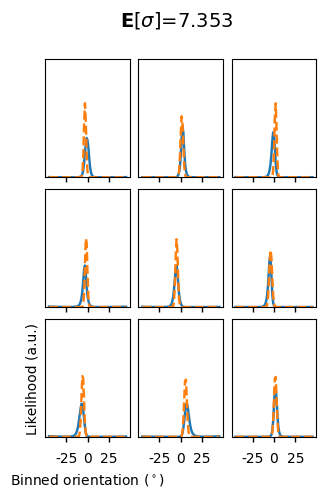

In [727]:
from itertools import count

y = net(valid_x)
#val, idx = torch.max(y, 1)
yd = y.data.cpu().numpy()


yd = np.exp(yd)
yd = yd / yd.sum(axis=1, keepdims=True)

gt = np.exp(valid_logl)
gt = gt / gt.sum(axis=1, keepdims=True)


loc = yd.argmax(axis=1)
loc_gt = gt.argmax(axis=1)
ds = (np.arange(nbins) - loc[:, None])**2

avg_sigma = np.mean(np.sqrt(np.sum(yd * ds, axis=1))) * delta


n_rows = 3
n_cols = 3
fig, axs = plt.subplots(n_rows, n_cols, sharex=True, sharey=True, figsize=(3.5, 5), dpi=100)

p = np.random.permutation(len(yd))

for c, ((i, j), ax) in zip(p, np.ndenumerate(axs)):
    line, = ax.plot(pv, yd[c])
    ax.plot(pv, gt[c], '--')
    ax.set_ylim([0, 0.5])
    ax.set_yticks([])
    if j == 0 and i == n_rows-1:
        ylabel = ax.set_ylabel('Likelihood (a.u.)', fontsize=10)
        print(ylabel.get_transform())
        ax.set_xlabel('Binned orientation ($^\circ$)', fontsize=10)
        ax.set_xticks([-25, 0, 25])
        
    else:
        pass
        #ax.set_xticklabels([])
    ax.set_xticklabels([-25, 0, 25], fontsize=10)
fig.subplots_adjust(wspace=0.1, hspace=0.1)


fig.suptitle("$\mathbf{{E}}[\sigma]$={:0.3f}".format(avg_sigma), fontsize=14)
fig.savefig('')

2.592216102145169


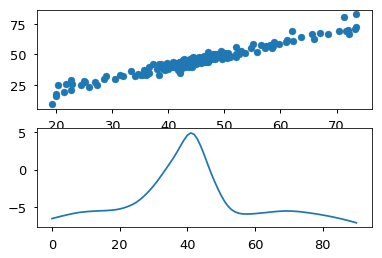

In [728]:
net.eval()
y = net(valid_x)


y = y + prior

idx, _ = stat_logp(y)
#val, idx = torch.max(y, 1)
yd = y.data.cpu().numpy()


plt.subplot(211)
t_hat = idx.data.cpu().numpy()
plt.scatter(t_hat, valid_ori)


print(np.sqrt(np.mean((t_hat - valid_ori)**2)) * delta)

plt.subplot(212)

plt.plot(yd[47])

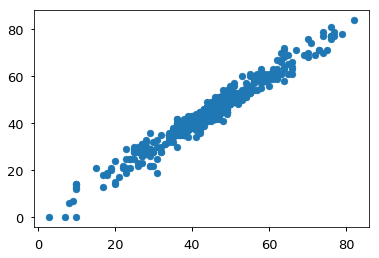

In [128]:
plt.scatter(valid_t, loc)

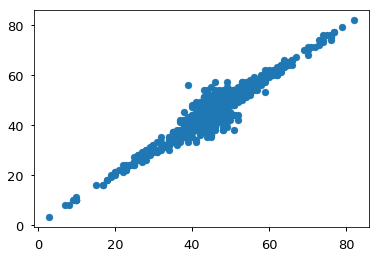

In [129]:
plt.scatter(valid_t, loc_gt)

## Measure std of likelihood functions

In [21]:
loc = yd.argmax(axis=1)
ds = (np.arange(nbins) - loc[:, None])**2

np.mean(np.sqrt(np.sum(yd * ds, axis=1)))

8.930213504892635

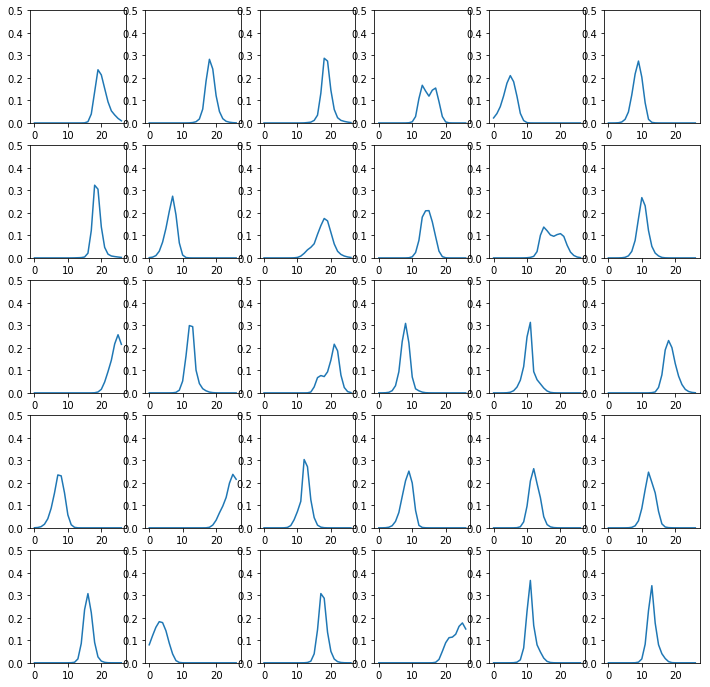

In [44]:
from itertools import count

y = net(valid_x)
val, idx = torch.max(y, 1)
yd = y.data.cpu().numpy()
yd = np.exp(yd)
yd = yd / yd.sum(axis=1, keepdims=True)

fig, axs = plt.subplots(5, 6, figsize=(12, 12))
for i, ax in zip(count(), axs.ravel()):
    ax.plot(yd[i])
    ax.set_ylim([0, 0.5])

In [ ]:
data = fetch(class_discrimination.ClassDiscriminationTrial * class_discrimination.SpikeCountTrials * class_discrimination.CSCLookup  & class_discrimination.CleanSpikeCountTrials & self, '*');
            data = dj.struct.sort(data, 'trial_num');
            contrast = fetchn(self, 'dataset_contrast');
            all_contrast = arrayfun(@num2str, [data.contrast], 'UniformOutput', false);
            pos = strcmp(all_contrast, contrast);
            dataSet = data(pos);
            if pack
                dataSet = packData(dataSet);
            end